In [16]:
import sys
module_path = 'C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT'
sys.path.insert(1, module_path)
import Meta_SCMT
import numpy as np
import matplotlib.pyplot as plt

In [17]:
GP = {
    'dim' : 1, #dim : 1 or 2.
    'modes' : 1, #number of modes with in a single waveguide. modes <= 2 is usually good enough.
    'period' : 0.28,
    'res' : 20, #resolution within one period
    'downsample_ratio': 1, #between (0, 1] for the output periodic resolution, it will be int(round(downsample_ratio * res))
    'wh' : 0.6, #waveguide height
    'lam' : 0.59,
    'n_sub' : 1.46, #the refractive index of substrate.
    'n_wg' : 2.4,# the refractive index of waveguide
    'h_min' : 0.06, #h_min, and h_max define the range of the width of waveguide.
    'h_max' : 0.27,
    'dh' : 0.01, #the step size of h.
    'path' : "sim_cache_590nm/", #the inter state store path            
}
sim = Meta_SCMT.Sim(**GP)

C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\simulator.py:72: UserWarning: Your global parameters have changed. be careful loading any cached data, it may be in consist!
  warnings.warn('Your global parameters have changed. be careful loading any cached data, it may be in consist!')


If dowmsample_ratio changed, if only need to rerun fitting E.
It is ok to change n_sub, which is decoupled with the cached data.


# From step 1 to step 3, you parpare the data and model you need to build a SCMT model. Once done, the cache data is stored in "sim_cache_1D" directory. When you need to run or build your model agian, you just load the data from cache.

# step1 generate modes

# it's ok to see warning like invalid value encountered in sqrt. This is because when using fsolve function, it can feed bad bata in function. This won't influence the final results.

In [5]:
sim.gen_modes.gen(load = False)
sim.gen_modes.count_modes()

C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\modes1D.py:128: RuntimeWarning: invalid value encountered in sqrt
  gamma = np.sqrt(beta**2 - (k*n0)**2)
C:\Users\94735\.conda\envs\pytorch1.9_env\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\modes1D.py:129: RuntimeWarning: invalid value encountered in sqrt
  kai = np.sqrt((k*n1)**2 - beta**2)
C:\Users\94735\.conda\envs\pytorch1.9_env\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


generated modes lib saved at:sim_cache_TiO2_1mode/modes_lib.npy
total keys:  23
number of non zero modes:  [23.]


# step 1.1 check correctness of the generated modes.

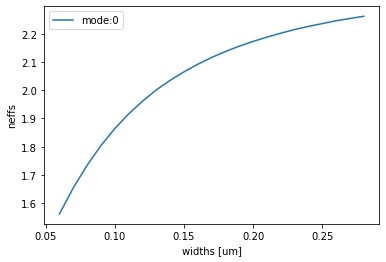

In [6]:
sim.gen_modes.vis_neffs()

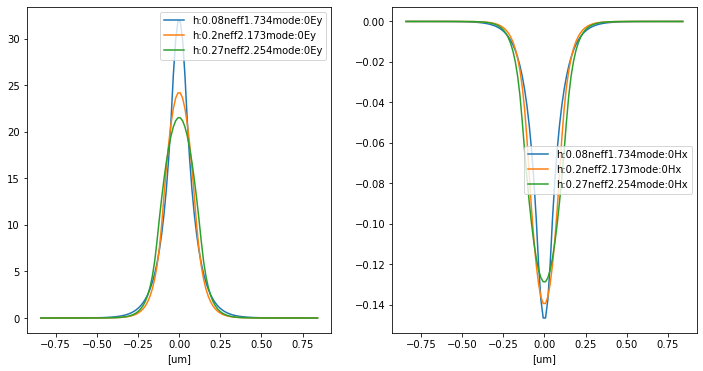

In [7]:
# randomly visualize some generated modes.
H = [0.08, 0.2, 0.27]
sim.gen_modes.vis_field(H)

# step 2, fit a function (the fully connected network) to output the effective refractive index given a width of waveguide. this function will be used in the SCMT model. (The solid line represent the original data, dashed line represent the function output).
# after the fitting the data will be saved in the "sim_cache..." directory. 

using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:97.064000%].
total epoches:10000 [curr: 1000 relative_error:0.781000%].
total epoches:10000 [curr: 2000 relative_error:0.438000%].
total epoches:10000 [curr: 3000 relative_error:0.388000%].
total epoches:10000 [curr: 4000 relative_error:0.362000%].
total epoches:10000 [curr: 5000 relative_error:0.281000%].
total epoches:10000 [curr: 6000 relative_error:0.216000%].
total epoches:10000 [curr: 7000 relative_error:0.213000%].
total epoches:10000 [curr: 8000 relative_error:0.198000%].
total epoches:10000 [curr: 9000 relative_error:0.191000%].
total epoches:10000 [curr: 9999 relative_error:0.191000%].
fitting error > 0.1%, increase total steps or number of layers in fullconnected network.(note: < 1% is good enough, but < 0.1% is the safest.)
model saved.


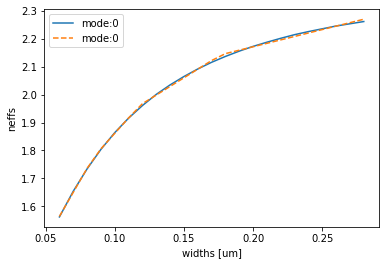

In [8]:
sim.fitting_neffs.fit(vis=True, layers = 4, nodes = 128)

# step 2.1 check the correctness of fitting.

In [9]:
neffs = sim.fitting_neffs.apply(H)
print(neffs)

[[1.7361051]
 [2.1716921]
 [2.2579176]]


# step 3.1 fit a function that given the widths and the distance between two waveguides i and j, output the coupling efficient Cij for the combination of all modes. 
# Eg: fit_c(hi, hj, dis) -> [cij_00, cij_01, cij_10, cij_11] if you have two modes per waveguide.

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 96.75it/s]


C dataset generated. dataset size: 3174
C dataset saved.
using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:116.522000%].
total epoches:10000 [curr: 1000 relative_error:1.547000%].
total epoches:10000 [curr: 2000 relative_error:0.404000%].
total epoches:10000 [curr: 3000 relative_error:0.143000%].
total epoches:10000 [curr: 4000 relative_error:0.121000%].
total epoches:10000 [curr: 5000 relative_error:0.205000%].
total epoches:10000 [curr: 6000 relative_error:0.150000%].
total epoches:10000 [curr: 7000 relative_error:0.045000%].
fitting error < 0.1%, accurate enough, stoped.
model saved.


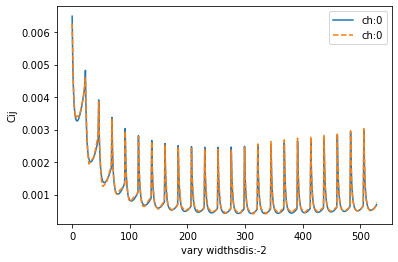

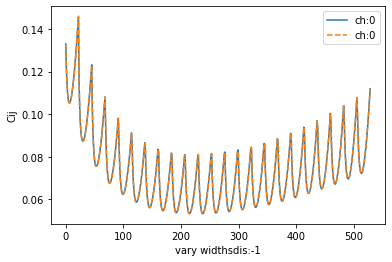

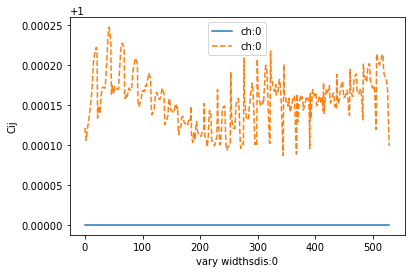

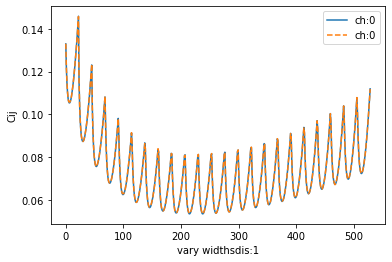

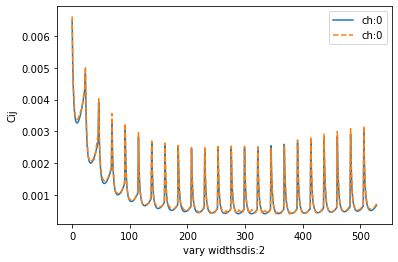

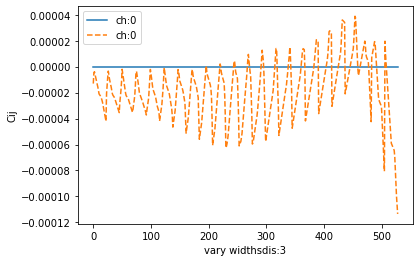

In [10]:
sim.fftting_C.fit(load = False, vis=True, steps = 10000, nodes = 128, layers = 6)

# the max(C_ij) indicate how strong your system's coupling is. the sweet point is below 0.5 but above 0.1, based on experience.

# step 3.2 fit a function that given the width of the waveguide, output the Ey field for each mode.

using device:  cuda
decay_rate: 0.79
total epoches:10000 [curr:    0 relative_error:100.431000%].
total epoches:10000 [curr: 1000 relative_error:10.108000%].
total epoches:10000 [curr: 2000 relative_error:10.159000%].
total epoches:10000 [curr: 3000 relative_error:9.899000%].
total epoches:10000 [curr: 4000 relative_error:0.810000%].
total epoches:10000 [curr: 5000 relative_error:0.491000%].
total epoches:10000 [curr: 6000 relative_error:0.464000%].
total epoches:10000 [curr: 7000 relative_error:0.472000%].
total epoches:10000 [curr: 8000 relative_error:0.384000%].
total epoches:10000 [curr: 9000 relative_error:0.347000%].
total epoches:10000 [curr: 9999 relative_error:0.310000%].
fitting error > 0.1%, increase total steps or number of layers in fullconnected network.(note: < 1% is good enough, but < 0.1% is the safest.)
model saved.


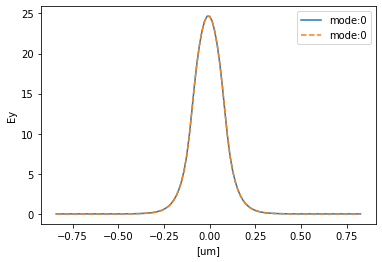

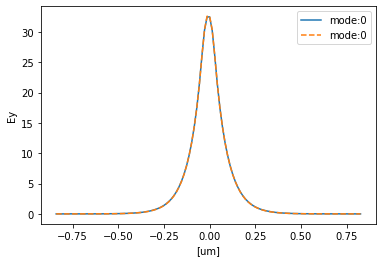

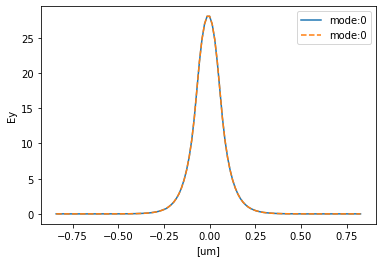

In [11]:
#randomly select 3 modes to visualize
sim.fftting_E.fit(vis=True, nodes = 128, layers = 6)

# step 3.3 fitting K, this is similiar to fit C

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 68.89it/s]


K dataset generated. dataset size: 3174
K dataset saved.
using device:  cuda
decay_rate: 0.79
total epoches:30000 [curr:    0 relative_error:134.547000%].
total epoches:30000 [curr: 3000 relative_error:2.216000%].
total epoches:30000 [curr: 6000 relative_error:0.472000%].
total epoches:30000 [curr: 9000 relative_error:0.579000%].
total epoches:30000 [curr:12000 relative_error:0.478000%].
total epoches:30000 [curr:15000 relative_error:0.107000%].
total epoches:30000 [curr:18000 relative_error:0.243000%].
total epoches:30000 [curr:21000 relative_error:0.198000%].
total epoches:30000 [curr:24000 relative_error:0.094000%].
fitting error < 0.1%, accurate enough, stoped.
model saved.


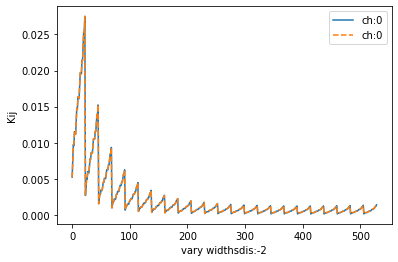

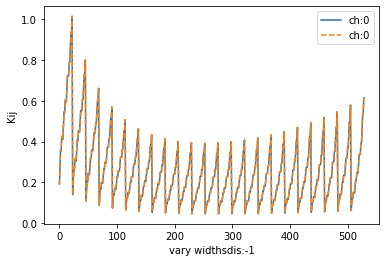

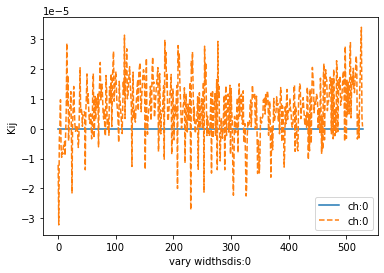

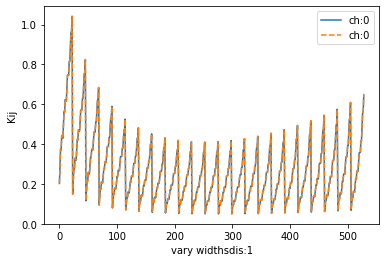

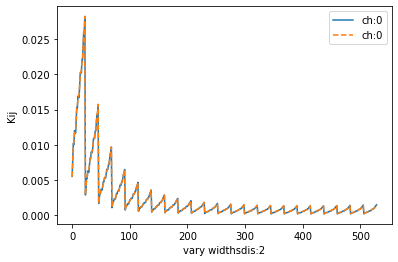

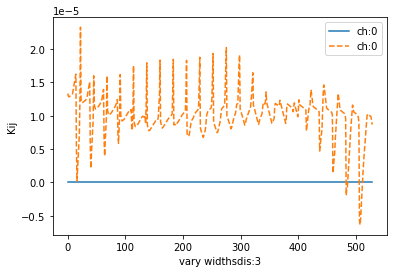

In [12]:
sim.fftting_K.fit(load = False, vis=True, nodes = 128,layers = 6, steps = 30000)

# step 4 run a forward simulation.

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


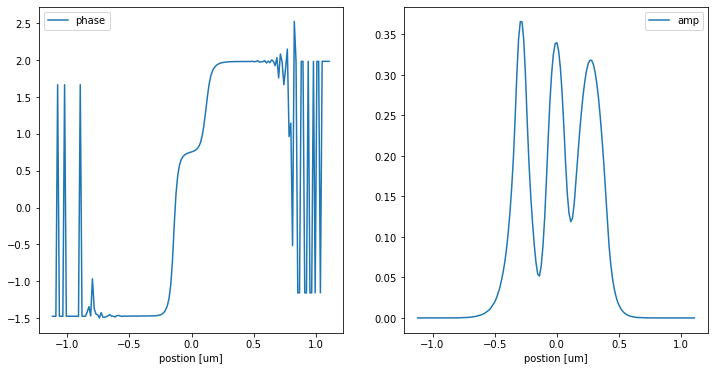

In [3]:
N = 3
#the widths of waveguides.
wgs = np.array([0.08, 0.15, 0.27])
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


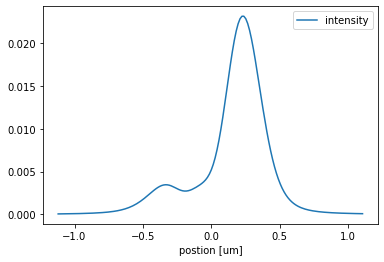

In [4]:
#far field, the field propagates a distance in free space.
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= True)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

# if no coupling: quite different from the scmt case, which indicate the coupling is important in this case.

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initialized by loaded h_paras.


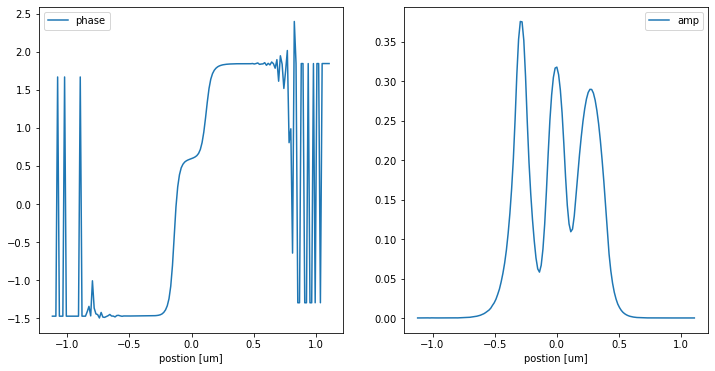

In [5]:
N = 3
#the widths of waveguides.
wgs = np.array([0.08, 0.15, 0.27])
prop_dis = 0.25 * N * GP['period']
#near field. the field at the exit of the waveguides.
sim.scmt.init_model(N, prop_dis, COUPLING = False, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward()
sim.scmt.vis_field(E_out)

# step 4.1 we do a fullwave simulation using Tidy3d to validate our forward process.

# gen library for PBA design

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:51<00:00,  2.22s/it]


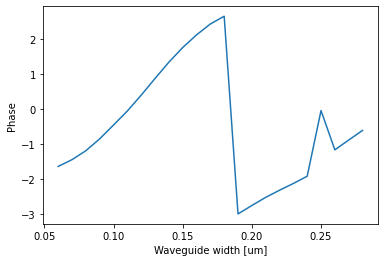

PBA width phase map saved.


In [6]:
sim.PBA.gen_lib()

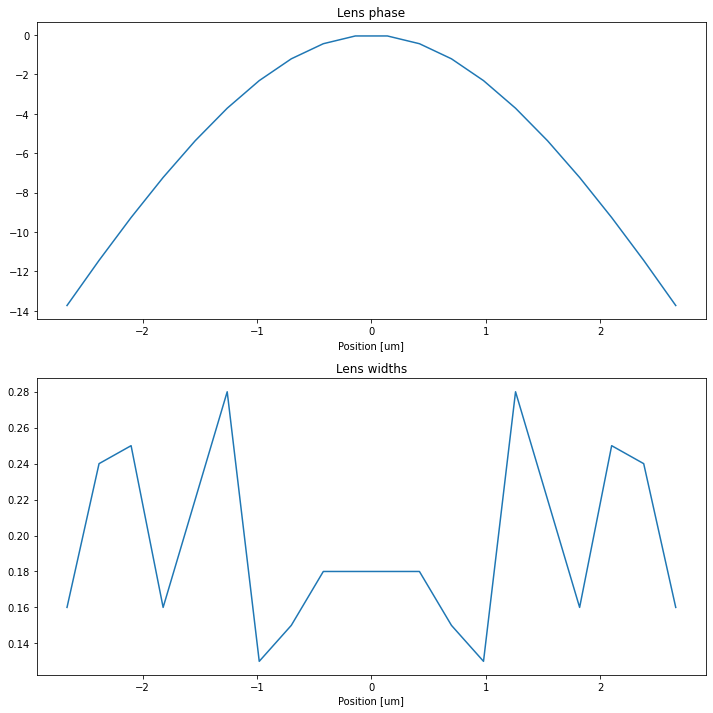

In [21]:
N = 20
theta = 0
NA = 0.8
prop_dis = 0.5 * N * GP['period'] * np.sqrt((1 - NA**2)/NA**2)
wgs = sim.PBA.design_lens(N, prop_dis, load = True)
np.save(f"PBA_lens_N{N}_lam{GP['lam']}um.npy", wgs)

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initial widths larger than h_max, replaced by h_max
initialized by loaded h_paras.


C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\SCMT_1D.py:197: UserWarning: bad initial widths for waveguides.
  warnings.warn("bad initial widths for waveguides.")


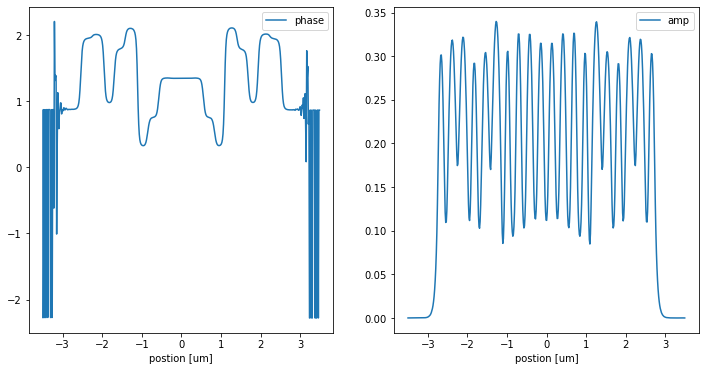

In [19]:
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= False)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)
E_scmt = E_out

coo_sparse generated.
coo_sparse generated.
dis model input generated.
initial widths larger than h_max, replaced by h_max
initialized by loaded h_paras.


C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\SCMT_1D.py:197: UserWarning: bad initial widths for waveguides.
  warnings.warn("bad initial widths for waveguides.")


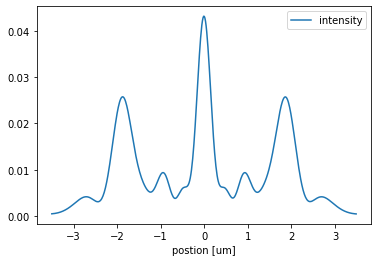

In [22]:
sim.scmt.init_model(N, prop_dis, COUPLING = True, init_hs= wgs, far_field= True)
E_out =sim.scmt.forward(theta = theta)
sim.scmt.vis_field(E_out)

# fullwave

Fullwave resolution: 50
total running time: 9.840140789276964e-13
Initializing simulation...
Mesh step (micron): [2.00e-02, 2.00e-02, 2.00e-02].
Simulation domain in number of grid points: [310, 1, 265].
Total number of computational grid points: 8.22e+04.
Total number of time steps: 28387.
Estimated data size (GB) of monitor monitor: 0.0032.
Estimated data size (GB) of monitor monitor_1: 0.0000.


C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\fullwave_1D.py:178: UserWarning: Fullwave is expensive and slow. Only do fullwave on small devices. And low resolution can be inaccurate.
  warnings.warn("Fullwave is expensive and slow. Only do fullwave on small devices. And low resolution can be inaccurate.")
C:/Users/94735/OneDrive - UW-Madison/My Projects/CMT_and_inverse_design/Meta_SCMT\Meta_SCMT\fullwave_1D.py:180: UserWarning: initial widths larger than h_max, bad initial widths for waveguides.
  warnings.warn("initial widths larger than h_max, bad initial widths for waveguides.")


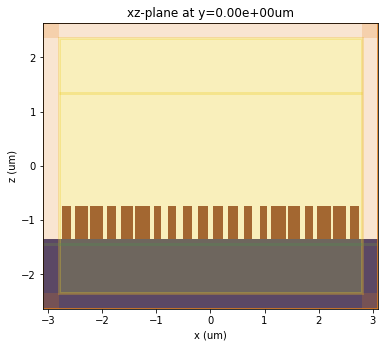

In [10]:
sim.fullwave.init_sim(prop_dis, N, wgs, res = 50, theta = theta, backend = 'tidy3d')

In [11]:
sim.fullwave.upload(task_name="1D_lens_N20")
sim.fullwave.download(data_path="output_tidy3d/")

Using Tidy3D credentials from stored file
Uploading the json file...
Project '1D_lens_N20' status: success...                                  

Simulation domain Nx, Ny, Nz: [310, 1, 265]
Applied symmetries: [0, 0, 0]
Number of computational grid points: 8.2150e+04.
Using subpixel averaging: True
Number of time steps: 28387
Automatic shutoff factor: 1.00e-05
Time step (s): 3.4665e-17

Compute source modes time (s):     0.3075
Compute monitor modes time (s):    0.3031

Rest of setup time (s):            0.2959

Starting solver...
- Time step    452 / time 1.57e-14s (  1 % done), field decay: 1.00e+00
- Time step   1135 / time 3.93e-14s (  4 % done), field decay: 1.30e-01
- Time step   2270 / time 7.87e-14s (  8 % done), field decay: 1.91e-02
- Time step   3406 / time 1.18e-13s ( 12 % done), field decay: 4.95e-03
- Time step   4541 / time 1.57e-13s ( 16 % done), field decay: 2.59e-03
- Time step   5677 / time 1.97e-13s ( 20 % done), field decay: 1.83e-03
- Time step   6812 / time 2.36e-

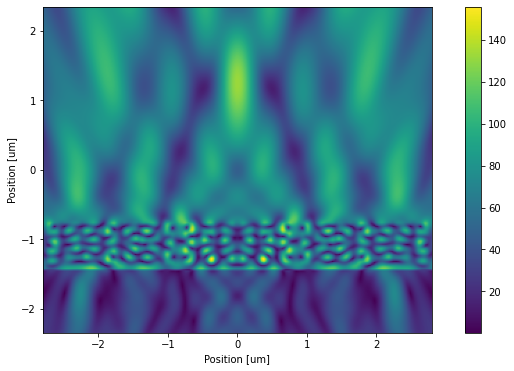

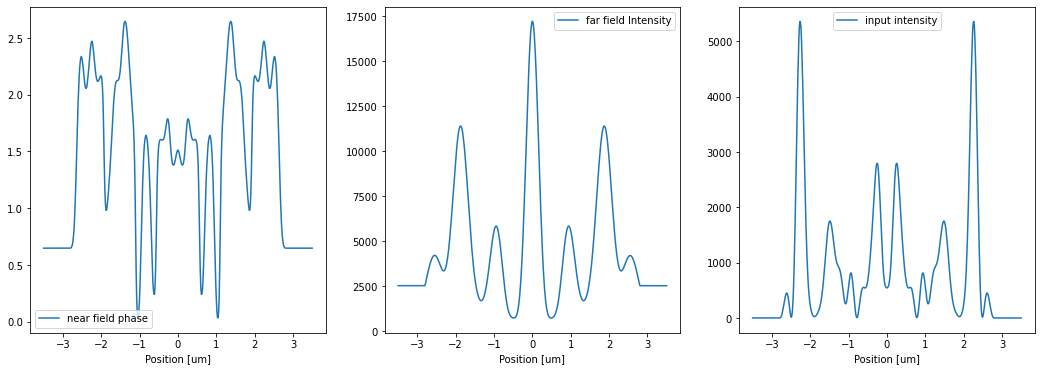

In [12]:
Ey_xz_raw, data_near, data_far = sim.fullwave.vis_monitor()

In [13]:
def get_phase_offset(E1, E2):
    L2_dis = np.inf
    theta_opt = 0
    for theta in np.linspace(0, 2 * np.pi, 300):
        E_temp = E1 * np.exp(1j * theta)
        phase_temp = np.angle(E_temp)
        phase2 = np.angle(E2)
        dis_temp = ((phase_temp - phase2)**2).sum()
        if dis_temp < L2_dis:
            L2_dis = dis_temp
            theta_opt = theta
    print("minimum phase l2 dis:", L2_dis)
    return theta_opt

In [14]:
E_fullwave = data_near['Ey']
b = 50
ph1_offset = get_phase_offset(E_scmt[b:-b], E_fullwave[b:-b])

minimum phase l2 dis: 53.18737949930551


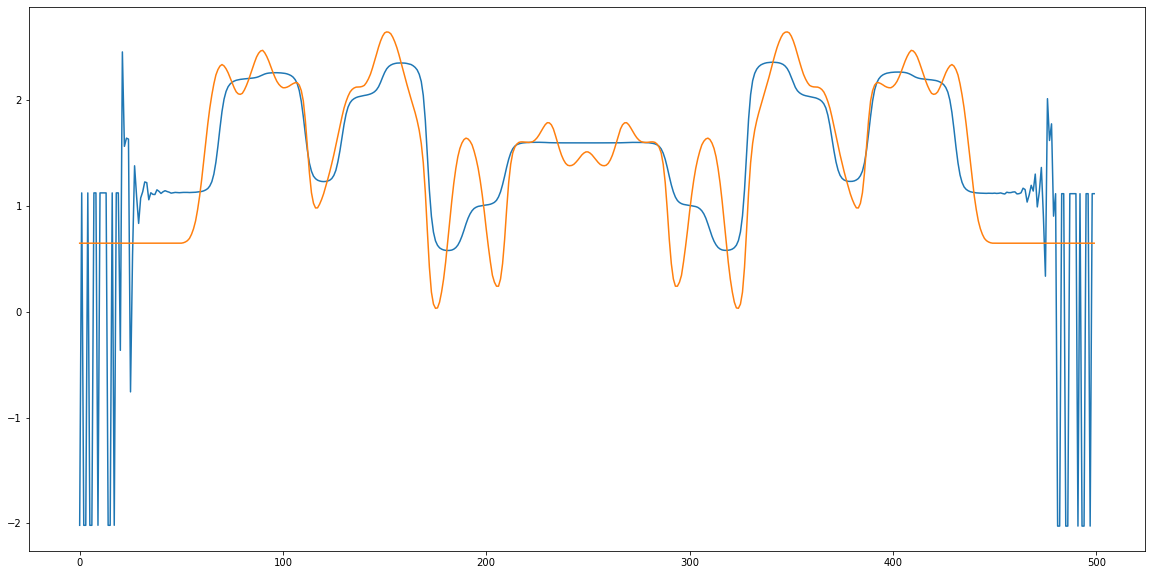

In [15]:
plt.figure(figsize = (20, 10))
plt.plot(np.angle(E_scmt * np.exp(1j * ph1_offset)))
plt.plot(np.angle(E_fullwave))

# the phase of fullwave

In [55]:
fw_phase = np.flip(np.angle(Ey_xz_raw), axis = 0)

In [56]:
import plotly.express as px

In [57]:
fig = px.imshow(fw_phase)
fig.show()

In [58]:
fw_phase.shape

(235, 350)

In [59]:
20 *20

0.014000000000000002